# **IE Sustainability Datathon 2023:** 03_ML Models (Day - Random Forest - Sep. Sectors)

## 0. GENERAL CONFIG

### Modules & Libraries

In [ ]:
#conda update scikit-learn

In [ ]:
!pip install category_encoders

In [ ]:
!pip install optuna

In [ ]:
# IMPORT MODULES

# Base -----------------------------------------------------------
import pandas as pd
import numpy as np
import pathlib
import datetime as dt
from scipy.stats import norm
from datetime import datetime
#import pandas_profiling
from math import *

pd.options.display.float_format = "{:,.2f}".format

# Viz ------------------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.colors as ma
import matplotlib.font_manager as fm
import seaborn as sns
import plotly
import plotnine
from plotnine import *
#import patchworklib as pw

%matplotlib inline

In [ ]:
import time
from datetime import timedelta

In [ ]:
import sklearn
import matplotlib
import scipy
import statsmodels
import mlxtend
import category_encoders
import seaborn
import xgboost

In [ ]:
from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import OrdinalEncoder
from category_encoders import OrdinalEncoder

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
import optuna

In [ ]:
#importing all the plot functions
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

### Prepared Functions

In [ ]:
def miss_info(df_data):

    # MISSING VALUES INFO (BY COLUMNS)

    df_colsnan = pd.DataFrame()
    df_colsnan['dtypes'] = df_data.apply(lambda x: x.dtypes)
    df_colsnan['nan'] = df_data.isnull().sum()
    df_colsnan['perc_nan'] = (df_data.isnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_nan'] = df_colsnan['perc_nan'].round(2)
    df_colsnan['not_nan'] = df_data.notnull().sum()
    df_colsnan['perc_not_nan'] = (df_data.notnull().sum() / df_data.shape[0]) * 100
    df_colsnan['perc_not_nan'] = df_colsnan['perc_not_nan'].round(2)
    df_colsnan['unique_values'] = df_data.apply(lambda x: len(x.unique()) )
    df_colsnan['neg_values'] = df_data.apply(lambda x: x.lt(0).sum() if x.dtypes == 'float64' else 'NA')
    df_colsnan.reset_index(inplace=True)
    df_colsnan.rename(columns={'index':'col_name'}, inplace=True)

    return df_colsnan

In [ ]:
def RowKey_transf(x):
    myDate = str(x.date())
    return dt.datetime.strptime(myDate, '%Y-%m-%d').strftime('%Y-%m-%dT00:00:00.000Z')

In [ ]:
def mape_corr(y_true, y_pred):

  mape_value = mean_absolute_percentage_error(y_true, y_pred)
  if mape_value > 1500 and (y_true-y_pred).mean()<10:
    mape_value = 0

  return mape_value

### General info & Code

In [ ]:
'''
cat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)

num_vars = list(df_model.select_dtypes(include=["number"]).columns)


# DATE COLUMN
df_model['settlementDate'] = pd.to_datetime(df_model['settlementDate'])


# Transforming date to CATEGORICAL ORDINAL
order = list(df_model['settlementDate'].unique())
order.sort()
data = df_model['settlementDate']
df_model['settlementDate'] = pd.Categorical(data, order, ordered=True)


# CATEGORICAL NOMINAL
# Column "recordtype"
data = df_model['recordtype']
df_model['recordtype'] = pd.Categorical(data, ordered=False)


'''

'\ncat_vars = list(df_model.select_dtypes(exclude=["number"]).columns)\n\nnum_vars = list(df_model.select_dtypes(include=["number"]).columns)\n\n\n# DATE COLUMN\ndf_model[\'settlementDate\'] = pd.to_datetime(df_model[\'settlementDate\'])\n\n\n# Transforming date to CATEGORICAL ORDINAL\norder = list(df_model[\'settlementDate\'].unique())\norder.sort()\ndata = df_model[\'settlementDate\']\ndf_model[\'settlementDate\'] = pd.Categorical(data, order, ordered=True)\n\n\n# CATEGORICAL NOMINAL\n# Column "recordtype"\ndata = df_model[\'recordtype\']\ndf_model[\'recordtype\'] = pd.Categorical(data, ordered=False)\n\n\n'

## 1. LOADING & PREPARING DATASET

### Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/GDrive')

Drive already mounted at /content/GDrive; to attempt to forcibly remount, call drive.mount("/content/GDrive", force_remount=True).


In [ ]:
file_path = "/content/GDrive/MyDrive/IE - Datathon 2023/01_Data/DF_1prep76 (IMPUTED).csv"

In [ ]:
df_1prep76 = pd.read_csv(file_path)
df_1prep76

,RowKey_Date,DiaSem,Clasif_Lab,Clasif_Fest,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,DiaSem_SIN,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,Lunes,Laborable,No Festivo,2,8,2021,0,0,0.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1,0,0,0
1,2021-08-03,Martes,Laborable,No Festivo,3,8,2021,0,0,0.78,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1,0,0,0
2,2021-08-04,Miercoles,Laborable,No Festivo,4,8,2021,0,0,0.97,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0,1,0,0
3,2021-08-05,Jueves,Laborable,No Festivo,5,8,2021,0,0,0.43,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0,1,0,0
4,2021-08-06,Viernes,Laborable,No Festivo,6,8,2021,0,0,-0.43,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2022-12-08,Jueves,Laborable,Festivo,8,12,2022,0,0,0.43,...,11.80,77.40,"1,005.20",9.90,94.11,41.67,1,0,1,0
494,2022-12-09,Viernes,Laborable,No Festivo,9,12,2022,0,1,-0.43,...,7.00,172.40,"1,001.80",9.50,90.65,20.83,1,0,1,0
495,2022-12-10,Sabado,No Laborable,No Festivo,10,12,2022,0,0,-0.97,...,0.60,119.00,"1,009.80",8.40,87.26,13.04,1,0,1,0
496,2022-12-11,Domingo,No Laborable,No Festivo,11,12,2022,0,0,-0.78,...,31.60,114.90,"1,007.30",10.60,91.03,37.50,0,0,1,1


In [ ]:
df_1prep76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RowKey_Date            498 non-null    object 
 1   DiaSem                 498 non-null    object 
 2   Clasif_Lab             498 non-null    object 
 3   Clasif_Fest            498 non-null    object 
 4   N_DiaMes               498 non-null    int64  
 5   N_Mes                  498 non-null    int64  
 6   N_Ano                  498 non-null    int64  
 7   Lab_PrevioFest         498 non-null    int64  
 8   Lab_PostFest           498 non-null    int64  
 9   DiaSem_SIN             498 non-null    float64
 10  DiaSem_COS             498 non-null    float64
 11  Dia_SIN                498 non-null    float64
 12  Dia_COS                498 non-null    float64
 13  Mes_SIN                498 non-null    float64
 14  Mes_COS                498 non-null    float64
 15  VD_Car

In [ ]:
df_1prep76.describe()

,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,DiaSem_SIN,DiaSem_COS,Dia_SIN,Dia_COS,Mes_SIN,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
count,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,...,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00
mean,15.54,7.38,"2,021.69",0.02,0.03,0.00,0.00,0.02,0.01,-0.21,...,0.65,327.56,"1,018.17",6.59,57.95,2.19,0.62,0.31,0.16,0.06
std,8.82,3.34,0.46,0.14,0.17,0.71,0.71,0.71,0.71,0.70,...,3.10,123.29,5.49,4.09,21.18,7.38,0.49,0.46,0.37,0.25
min,1.00,1.00,"2,021.00",0.00,0.00,-0.97,-0.90,-1.00,-1.00,-1.00,...,0.00,55.10,"1,001.80",-6.40,10.49,0.00,0.00,0.00,0.00,0.00
25%,8.00,5.00,"2,021.00",0.00,0.00,-0.78,-0.90,-0.72,-0.67,-0.87,...,0.00,243.33,"1,014.30",3.90,39.55,0.00,0.00,0.00,0.00,0.00
50%,15.00,8.00,"2,022.00",0.00,0.00,0.00,-0.22,0.00,-0.05,-0.50,...,0.00,341.15,"1,017.70",6.90,60.02,0.00,1.00,0.00,0.00,0.00
75%,23.00,10.00,"2,022.00",0.00,0.00,0.78,0.62,0.74,0.69,0.50,...,0.00,436.53,"1,021.50",9.28,76.24,0.00,1.00,1.00,0.00,0.00
max,31.00,12.00,"2,022.00",1.00,1.00,0.97,1.00,1.00,1.00,1.00,...,37.20,557.60,"1,033.10",16.70,97.78,79.17,1.00,1.00,1.00,1.00


### Dataset preparation

In [ ]:
df_1prep76.columns

Index(['RowKey_Date', 'DiaSem', 'Clasif_Lab', 'Clasif_Fest', 'N_DiaMes',
       'N_Mes', 'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN',
       'DiaSem_COS', 'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS',
       'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera',
       'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid', 'wdir',
       'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip',
       'solarradiation', 'sealevelpressure', 'dew', 'humidity', 'precipcover',
       'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast'],
      dtype='object')

In [ ]:
selcols_order = ['RowKey_Date', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid',
                 'DiaSem', 'Clasif_Lab', 'Clasif_Fest','N_DiaMes', 'N_Mes', 'N_Ano', 'Lab_PrevioFest',
                 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS','Mes_SIN', 'Mes_COS',
                 'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation', 'sealevelpressure',
                 'dew', 'humidity', 'precipcover', 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast']

In [ ]:
df_1prep76 = df_1prep76[selcols_order].copy()
df_1prep76

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,110.09,212.88,"1,461.88",216.33,446.82,192.36,644.48,"1,307.10",Lunes,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1,0,0,0
1,2021-08-03,106.67,181.24,"1,440.94",193.02,422.14,212.30,665.10,"1,321.60",Martes,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1,0,0,0
2,2021-08-04,74.18,179.96,"1,449.69",162.08,436.42,215.27,665.57,"1,338.00",Miercoles,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0,1,0,0
3,2021-08-05,14.48,201.64,"1,470.19",209.40,431.04,185.43,645.37,"1,279.70",Jueves,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0,1,0,0
4,2021-08-06,21.05,196.12,"1,396.38",212.27,411.49,202.91,651.12,"1,274.80",Viernes,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2022-12-08,19.87,168.52,49.02,96.83,290.74,57.25,861.62,"1,046.60",Jueves,...,11.80,77.40,"1,005.20",9.90,94.11,41.67,1,0,1,0
494,2022-12-09,19.79,167.96,69.84,96.40,290.37,60.48,874.39,"1,053.50",Viernes,...,7.00,172.40,"1,001.80",9.50,90.65,20.83,1,0,1,0
495,2022-12-10,20.62,178.30,40.18,95.57,313.51,62.17,877.48,"1,082.30",Sabado,...,0.60,119.00,"1,009.80",8.40,87.26,13.04,1,0,1,0
496,2022-12-11,21.38,176.99,0.18,101.12,310.50,44.60,894.31,983.30,Domingo,...,31.60,114.90,"1,007.30",10.60,91.03,37.50,0,0,1,1


In [ ]:
df_1prep76.describe()

,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,N_DiaMes,N_Mes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
count,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,...,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00
mean,46.73,166.67,829.33,145.81,291.06,98.77,642.55,902.42,15.54,7.38,...,0.65,327.56,"1,018.17",6.59,57.95,2.19,0.62,0.31,0.16,0.06
std,61.44,80.27,536.42,84.08,152.76,48.25,155.09,314.89,8.82,3.34,...,3.10,123.29,5.49,4.09,21.18,7.38,0.49,0.46,0.37,0.25
min,0.13,0.00,0.00,0.00,0.00,40.04,11.97,0.00,1.00,1.00,...,0.00,55.10,"1,001.80",-6.40,10.49,0.00,0.00,0.00,0.00,0.00
25%,11.08,153.08,51.59,87.24,278.47,60.30,528.29,741.02,8.00,5.00,...,0.00,243.33,"1,014.30",3.90,39.55,0.00,0.00,0.00,0.00,0.00
50%,20.91,194.16,"1,044.69",134.59,340.06,80.64,586.08,822.75,15.00,8.00,...,0.00,341.15,"1,017.70",6.90,60.02,0.00,1.00,0.00,0.00,0.00
75%,42.62,219.22,"1,180.85",170.57,391.14,137.37,761.75,"1,164.70",23.00,10.00,...,0.00,436.53,"1,021.50",9.28,76.24,0.00,1.00,1.00,0.00,0.00
max,217.07,292.38,"1,579.94",585.98,518.26,232.84,973.55,"1,528.40",31.00,12.00,...,37.20,557.60,"1,033.10",16.70,97.78,79.17,1.00,1.00,1.00,1.00


In [ ]:
# DATE COLUMN
'''
RowKey_Date
'''

# Column "FECHA_ALTA_SUMINISTRO"
df_1prep76['RowKey_Date'] = pd.to_datetime(df_1prep76['RowKey_Date'])


In [ ]:
# CATEGORICAL NOMINAL
'''
DiaSem
Clasif_Lab
Clasif_Fest
'''

# Column "DiaSem"
data = df_1prep76['DiaSem']
df_1prep76['DiaSem'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Lab"
data = df_1prep76['Clasif_Lab']
df_1prep76['Clasif_Lab'] = pd.Categorical(data, ordered=False)

# Column "Clasif_Fest"
data = df_1prep76['Clasif_Fest']
df_1prep76['Clasif_Fest'] = pd.Categorical(data, ordered=False)


In [ ]:
# NUMERICAL DISCRETE
'''
N_DiaMes
N_Mes
N_Ano
Lab_PrevioFest
Lab_PostFest
'''

# Column "N_DiaMes"
df_1prep76['N_DiaMes'] = df_1prep76['N_DiaMes'].astype('int64')

# Column "N_Mes"
df_1prep76['N_Mes'] = df_1prep76['N_Mes'].astype('int64')

# Column "N_Ano"
df_1prep76['N_Ano'] = df_1prep76['N_Ano'].astype('int64')

# Column "Lab_PrevioFest"
df_1prep76['Lab_PrevioFest'] = df_1prep76['Lab_PrevioFest'].astype('int64')

# Column "Lab_PostFest"
df_1prep76['Lab_PostFest'] = df_1prep76['Lab_PostFest'].astype('int64')


In [ ]:
df_1prep76.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RowKey_Date            498 non-null    datetime64[ns]
 1   VD_Carretera-Urda      498 non-null    float64       
 2   VD_Centro              498 non-null    float64       
 3   VD_Churruca            498 non-null    float64       
 4   VD_Gasolinera          498 non-null    float64       
 5   VD_Planta              498 non-null    float64       
 6   VD_Poligono            498 non-null    float64       
 7   VD_Sur-Este            498 non-null    float64       
 8   VD_Valladolid          498 non-null    float64       
 9   DiaSem                 498 non-null    category      
 10  Clasif_Lab             498 non-null    category      
 11  Clasif_Fest            498 non-null    category      
 12  N_DiaMes               498 non-null    int64         
 13  N_Mes

In [ ]:
miss_info(df_1prep76)

,col_name,dtypes,nan,perc_nan,not_nan,perc_not_nan,unique_values,neg_values
0,RowKey_Date,datetime64[ns],0,0.00,498,100.00,498,NA
1,VD_Carretera-Urda,float64,0,0.00,498,100.00,479,0
2,VD_Centro,float64,0,0.00,498,100.00,413,0
3,VD_Churruca,float64,0,0.00,498,100.00,402,0
4,VD_Gasolinera,float64,0,0.00,498,100.00,474,0
5,VD_Planta,float64,0,0.00,498,100.00,459,0
6,VD_Poligono,float64,0,0.00,498,100.00,486,0
7,VD_Sur-Este,float64,0,0.00,498,100.00,494,0
8,VD_Valladolid,float64,0,0.00,498,100.00,470,0
9,DiaSem,category,0,0.00,498,100.00,7,NA


In [ ]:
df_1prep76.describe()

,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,N_DiaMes,N_Mes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
count,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,...,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00,498.00
mean,46.73,166.67,829.33,145.81,291.06,98.77,642.55,902.42,15.54,7.38,...,0.65,327.56,"1,018.17",6.59,57.95,2.19,0.62,0.31,0.16,0.06
std,61.44,80.27,536.42,84.08,152.76,48.25,155.09,314.89,8.82,3.34,...,3.10,123.29,5.49,4.09,21.18,7.38,0.49,0.46,0.37,0.25
min,0.13,0.00,0.00,0.00,0.00,40.04,11.97,0.00,1.00,1.00,...,0.00,55.10,"1,001.80",-6.40,10.49,0.00,0.00,0.00,0.00,0.00
25%,11.08,153.08,51.59,87.24,278.47,60.30,528.29,741.02,8.00,5.00,...,0.00,243.33,"1,014.30",3.90,39.55,0.00,0.00,0.00,0.00,0.00
50%,20.91,194.16,"1,044.69",134.59,340.06,80.64,586.08,822.75,15.00,8.00,...,0.00,341.15,"1,017.70",6.90,60.02,0.00,1.00,0.00,0.00,0.00
75%,42.62,219.22,"1,180.85",170.57,391.14,137.37,761.75,"1,164.70",23.00,10.00,...,0.00,436.53,"1,021.50",9.28,76.24,0.00,1.00,1.00,0.00,0.00
max,217.07,292.38,"1,579.94",585.98,518.26,232.84,973.55,"1,528.40",31.00,12.00,...,37.20,557.60,"1,033.10",16.70,97.78,79.17,1.00,1.00,1.00,1.00


### Categoric nominal variables

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#df_model = df_1prep76.copy()

In [ ]:
num_vars = list(df_1prep76.select_dtypes(include=["number"]).columns)
num_vars

['VD_Carretera-Urda',
 'VD_Centro',
 'VD_Churruca',
 'VD_Gasolinera',
 'VD_Planta',
 'VD_Poligono',
 'VD_Sur-Este',
 'VD_Valladolid',
 'N_DiaMes',
 'N_Mes',
 'N_Ano',
 'Lab_PrevioFest',
 'Lab_PostFest',
 'DiaSem_SIN',
 'DiaSem_COS',
 'Dia_SIN',
 'Dia_COS',
 'Mes_SIN',
 'Mes_COS',
 'wdir',
 'temp',
 'maxt',
 'visibility',
 'wspd',
 'solarenergy',
 'mint',
 'precip',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity',
 'precipcover',
 'cond_Partially-cloudy',
 'cond_Clear',
 'cond_Rain',
 'cond_Overcast']

In [ ]:
num_cols = df_1prep76[num_vars].copy()
num_cols.head()

,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,N_DiaMes,N_Mes,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,110.09,212.88,"1,461.88",216.33,446.82,192.36,644.48,"1,307.10",2,8,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1,0,0,0
1,106.67,181.24,"1,440.94",193.02,422.14,212.30,665.10,"1,321.60",3,8,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1,0,0,0
2,74.18,179.96,"1,449.69",162.08,436.42,215.27,665.57,"1,338.00",4,8,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0,1,0,0
3,14.48,201.64,"1,470.19",209.40,431.04,185.43,645.37,"1,279.70",5,8,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0,1,0,0
4,21.05,196.12,"1,396.38",212.27,411.49,202.91,651.12,"1,274.80",6,8,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0,1,0,0


In [ ]:
cat_vars = df_1prep76.select_dtypes(exclude=["number"]).columns
cat_vars

Index(['RowKey_Date', 'DiaSem', 'Clasif_Lab', 'Clasif_Fest'], dtype='object')

In [ ]:
# Separating between categorical nominal and categorical ordinal

LabelEncoder_vars = ['DiaSem', 'Clasif_Lab', 'Clasif_Fest']
OrdinalEncoder_vars = []

In [ ]:
cat_cols = df_1prep76[LabelEncoder_vars].copy()
#cat_cols = cat_cols.drop(columns=['RowKey_Date'], axis=1)
cat_cols.head(7)

,DiaSem,Clasif_Lab,Clasif_Fest
0,Lunes,Laborable,No Festivo
1,Martes,Laborable,No Festivo
2,Miercoles,Laborable,No Festivo
3,Jueves,Laborable,No Festivo
4,Viernes,Laborable,No Festivo
5,Sabado,No Laborable,No Festivo
6,Domingo,No Laborable,No Festivo


In [ ]:
categories_list = []

for x in LabelEncoder_vars:
  aux_list1 = list(cat_cols[x].unique())
  aux_list1.sort()

  aux_list2 = []

  for y in aux_list1:
    cat_name = x + '_' + y
    aux_list2.append(cat_name)

  categories_list = categories_list + aux_list2


In [ ]:
categories_list

['DiaSem_Domingo',
 'DiaSem_Jueves',
 'DiaSem_Lunes',
 'DiaSem_Martes',
 'DiaSem_Miercoles',
 'DiaSem_Sabado',
 'DiaSem_Viernes',
 'Clasif_Lab_Laborable',
 'Clasif_Lab_No Laborable',
 'Clasif_Fest_Festivo',
 'Clasif_Fest_No Festivo']

In [ ]:

categories_dict = {}

for x in categories_list:
  index_x = categories_list.index(x)
  categories_dict[index_x] = x

categories_dict


{0: 'DiaSem_Domingo',
 1: 'DiaSem_Jueves',
 2: 'DiaSem_Lunes',
 3: 'DiaSem_Martes',
 4: 'DiaSem_Miercoles',
 5: 'DiaSem_Sabado',
 6: 'DiaSem_Viernes',
 7: 'Clasif_Lab_Laborable',
 8: 'Clasif_Lab_No Laborable',
 9: 'Clasif_Fest_Festivo',
 10: 'Clasif_Fest_No Festivo'}

In [ ]:
ohe = OneHotEncoder(sparse=False)

In [ ]:
ohe.fit(cat_cols)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


OneHotEncoder(sparse=False, sparse_output=False)

In [ ]:
cat_cols_values = ohe.transform(cat_cols)

In [ ]:
cat_cols_enc = pd.DataFrame(cat_cols_values)
cat_cols_enc.rename(categories_dict, axis=1, inplace=True)
cat_cols_enc

,DiaSem_Domingo,DiaSem_Jueves,DiaSem_Lunes,DiaSem_Martes,DiaSem_Miercoles,DiaSem_Sabado,DiaSem_Viernes,Clasif_Lab_Laborable,Clasif_Lab_No Laborable,Clasif_Fest_Festivo,Clasif_Fest_No Festivo
0,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00
4,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...
493,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00
494,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00
495,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00
496,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00


In [ ]:
df_1prep76.iloc[:,range(9,40)]

,DiaSem,Clasif_Lab,Clasif_Fest,N_DiaMes,N_Mes,N_Ano,Lab_PrevioFest,Lab_PostFest,DiaSem_SIN,DiaSem_COS,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,Lunes,Laborable,No Festivo,2,8,2021,0,0,0.00,1.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1,0,0,0
1,Martes,Laborable,No Festivo,3,8,2021,0,0,0.78,0.62,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1,0,0,0
2,Miercoles,Laborable,No Festivo,4,8,2021,0,0,0.97,-0.22,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0,1,0,0
3,Jueves,Laborable,No Festivo,5,8,2021,0,0,0.43,-0.90,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0,1,0,0
4,Viernes,Laborable,No Festivo,6,8,2021,0,0,-0.43,-0.90,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,Jueves,Laborable,Festivo,8,12,2022,0,0,0.43,-0.90,...,11.80,77.40,"1,005.20",9.90,94.11,41.67,1,0,1,0
494,Viernes,Laborable,No Festivo,9,12,2022,0,1,-0.43,-0.90,...,7.00,172.40,"1,001.80",9.50,90.65,20.83,1,0,1,0
495,Sabado,No Laborable,No Festivo,10,12,2022,0,0,-0.97,-0.22,...,0.60,119.00,"1,009.80",8.40,87.26,13.04,1,0,1,0
496,Domingo,No Laborable,No Festivo,11,12,2022,0,0,-0.78,0.62,...,31.60,114.90,"1,007.30",10.60,91.03,37.50,0,0,1,1


In [ ]:
df_enc = cat_cols_enc.join(num_cols)
df_enc = df_1prep76[['RowKey_Date']].join(df_enc)
df_enc.head()

,RowKey_Date,DiaSem_Domingo,DiaSem_Jueves,DiaSem_Lunes,DiaSem_Martes,DiaSem_Miercoles,DiaSem_Sabado,DiaSem_Viernes,Clasif_Lab_Laborable,Clasif_Lab_No Laborable,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1,0,0,0
1,2021-08-03,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1,0,0,0
2,2021-08-04,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0,1,0,0
3,2021-08-05,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0,1,0,0
4,2021-08-06,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0,1,0,0


In [ ]:
df_enc.columns

Index(['RowKey_Date', 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes',
       'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
       'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable',
       'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'VD_Carretera-Urda',
       'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono',
       'VD_Sur-Este', 'VD_Valladolid', 'N_DiaMes', 'N_Mes', 'N_Ano',
       'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN',
       'Dia_COS', 'Mes_SIN', 'Mes_COS', 'wdir', 'temp', 'maxt', 'visibility',
       'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation',
       'sealevelpressure', 'dew', 'humidity', 'precipcover',
       'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast'],
      dtype='object')

In [ ]:
selcols_order = ['RowKey_Date', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid',
                 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes', 'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
                 'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable', 'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'N_DiaMes', 'N_Mes', 'N_Ano',
                 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS', 'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS',
                 'wdir', 'temp', 'maxt', 'visibility', 'wspd', 'solarenergy', 'mint', 'precip', 'solarradiation', 'sealevelpressure', 'dew', 'humidity', 'precipcover',
                 'cond_Partially-cloudy', 'cond_Clear', 'cond_Rain', 'cond_Overcast']

In [ ]:
df_enc = df_enc[selcols_order].copy()
df_enc

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,110.09,212.88,"1,461.88",216.33,446.82,192.36,644.48,"1,307.10",0.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1,0,0,0
1,2021-08-03,106.67,181.24,"1,440.94",193.02,422.14,212.30,665.10,"1,321.60",0.00,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1,0,0,0
2,2021-08-04,74.18,179.96,"1,449.69",162.08,436.42,215.27,665.57,"1,338.00",0.00,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0,1,0,0
3,2021-08-05,14.48,201.64,"1,470.19",209.40,431.04,185.43,645.37,"1,279.70",0.00,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0,1,0,0
4,2021-08-06,21.05,196.12,"1,396.38",212.27,411.49,202.91,651.12,"1,274.80",0.00,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2022-12-08,19.87,168.52,49.02,96.83,290.74,57.25,861.62,"1,046.60",0.00,...,11.80,77.40,"1,005.20",9.90,94.11,41.67,1,0,1,0
494,2022-12-09,19.79,167.96,69.84,96.40,290.37,60.48,874.39,"1,053.50",0.00,...,7.00,172.40,"1,001.80",9.50,90.65,20.83,1,0,1,0
495,2022-12-10,20.62,178.30,40.18,95.57,313.51,62.17,877.48,"1,082.30",0.00,...,0.60,119.00,"1,009.80",8.40,87.26,13.04,1,0,1,0
496,2022-12-11,21.38,176.99,0.18,101.12,310.50,44.60,894.31,983.30,1.00,...,31.60,114.90,"1,007.30",10.60,91.03,37.50,0,0,1,1


### Shifting weather data (7 days)

In [ ]:
df_encshift = df_enc.copy()

In [ ]:
target_cols = [x for x in list(df_encshift.columns) if x.startswith('VD_')]
target_cols

['VD_Carretera-Urda',
 'VD_Centro',
 'VD_Churruca',
 'VD_Gasolinera',
 'VD_Planta',
 'VD_Poligono',
 'VD_Sur-Este',
 'VD_Valladolid']

In [ ]:
clima_vars = list(df_encshift.columns)[31:]
clima_vars

['wdir',
 'temp',
 'maxt',
 'visibility',
 'wspd',
 'solarenergy',
 'mint',
 'precip',
 'solarradiation',
 'sealevelpressure',
 'dew',
 'humidity',
 'precipcover',
 'cond_Partially-cloudy',
 'cond_Clear',
 'cond_Rain',
 'cond_Overcast']

In [ ]:
for x in target_cols:
  new_col = x.replace('VD_','VD7_')
  df_encshift[new_col] = df_encshift[x].shift(periods=7)

In [ ]:
for x in clima_vars:
  new_col = x + '_7'
  df_encshift[new_col] = df_encshift[x].shift(periods=7)

df_encshift.drop(clima_vars, axis=1, inplace=True)

In [ ]:
df_enc.head(14)

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip,solarradiation,sealevelpressure,dew,humidity,precipcover,cond_Partially-cloudy,cond_Clear,cond_Rain,cond_Overcast
0,2021-08-02,110.09,212.88,"1,461.88",216.33,446.82,192.36,644.48,"1,307.10",0.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1,0,0,0
1,2021-08-03,106.67,181.24,"1,440.94",193.02,422.14,212.30,665.10,"1,321.60",0.00,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1,0,0,0
2,2021-08-04,74.18,179.96,"1,449.69",162.08,436.42,215.27,665.57,"1,338.00",0.00,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0,1,0,0
3,2021-08-05,14.48,201.64,"1,470.19",209.40,431.04,185.43,645.37,"1,279.70",0.00,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0,1,0,0
4,2021-08-06,21.05,196.12,"1,396.38",212.27,411.49,202.91,651.12,"1,274.80",0.00,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0,1,0,0
5,2021-08-07,17.48,201.39,"1,454.44",215.68,388.92,201.81,654.31,"1,333.50",0.00,...,0.00,499.40,"1,010.10",7.60,37.09,0.00,0,1,0,0
6,2021-08-08,42.78,200.60,"1,438.69",222.90,391.04,169.64,668.21,"1,275.80",1.00,...,0.00,499.10,"1,012.70",5.50,31.24,0.00,0,1,0,0
7,2021-08-09,33.34,221.00,"1,529.69",221.36,447.27,192.51,634.17,"1,244.30",0.00,...,0.00,463.10,"1,014.50",11.80,46.64,0.00,1,0,0,0
8,2021-08-10,29.89,186.61,"1,449.94",160.97,433.40,223.56,657.64,"1,235.30",0.00,...,0.00,412.40,"1,014.10",15.00,47.26,0.00,1,0,0,0
9,2021-08-11,23.73,214.44,"1,430.00",141.78,421.32,232.84,691.57,"1,238.70",0.00,...,0.00,348.30,"1,014.60",13.00,37.68,0.00,1,0,0,0


In [ ]:
df_encshift.iloc[:,range(31,df_encshift.shape[1])].head(14)

,VD7_Carretera-Urda,VD7_Centro,VD7_Churruca,VD7_Gasolinera,VD7_Planta,VD7_Poligono,VD7_Sur-Este,VD7_Valladolid,wdir_7,temp_7,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,110.09,212.88,"1,461.88",216.33,446.82,192.36,644.48,"1,307.10",247.13,24.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1.00,0.00,0.00,0.00
8,106.67,181.24,"1,440.94",193.02,422.14,212.30,665.10,"1,321.60",205.26,25.80,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1.00,0.00,0.00,0.00
9,74.18,179.96,"1,449.69",162.08,436.42,215.27,665.57,"1,338.00",264.83,27.30,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0.00,1.00,0.00,0.00


In [ ]:
df_encshift.head(20)

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-02,110.09,212.88,"1,461.88",216.33,446.82,192.36,644.48,"1,307.10",0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-08-03,106.67,181.24,"1,440.94",193.02,422.14,212.30,665.10,"1,321.60",0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-08-04,74.18,179.96,"1,449.69",162.08,436.42,215.27,665.57,"1,338.00",0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-05,14.48,201.64,"1,470.19",209.40,431.04,185.43,645.37,"1,279.70",0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-08-06,21.05,196.12,"1,396.38",212.27,411.49,202.91,651.12,"1,274.80",0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-08-07,17.48,201.39,"1,454.44",215.68,388.92,201.81,654.31,"1,333.50",0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-08-08,42.78,200.60,"1,438.69",222.90,391.04,169.64,668.21,"1,275.80",1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2021-08-09,33.34,221.00,"1,529.69",221.36,447.27,192.51,634.17,"1,244.30",0.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1.00,0.00,0.00,0.00
8,2021-08-10,29.89,186.61,"1,449.94",160.97,433.40,223.56,657.64,"1,235.30",0.00,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1.00,0.00,0.00,0.00
9,2021-08-11,23.73,214.44,"1,430.00",141.78,421.32,232.84,691.57,"1,238.70",0.00,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0.00,1.00,0.00,0.00


In [ ]:
df_encshift.drop(list(range(0,7)), axis=0, inplace=True)
df_encshift.reset_index(drop=True, inplace=True)
df_encshift.head(20)

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-09,33.34,221.00,"1,529.69",221.36,447.27,192.51,634.17,"1,244.30",0.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1.00,0.00,0.00,0.00
1,2021-08-10,29.89,186.61,"1,449.94",160.97,433.40,223.56,657.64,"1,235.30",0.00,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1.00,0.00,0.00,0.00
2,2021-08-11,23.73,214.44,"1,430.00",141.78,421.32,232.84,691.57,"1,238.70",0.00,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0.00,1.00,0.00,0.00
3,2021-08-12,30.11,187.74,"1,448.75",139.11,418.45,209.98,711.72,"1,212.30",0.00,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0.00,1.00,0.00,0.00
4,2021-08-13,20.03,223.59,"1,479.44",138.59,432.91,225.43,674.09,"1,278.60",0.00,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0.00,1.00,0.00,0.00
5,2021-08-14,33.14,199.91,"1,475.06",139.77,396.79,209.17,714.90,"1,308.60",0.00,...,0.00,499.40,"1,010.10",7.60,37.09,0.00,0.00,1.00,0.00,0.00
6,2021-08-15,75.95,196.97,"1,466.62",150.31,405.51,215.94,719.55,"1,287.60",1.00,...,0.00,499.10,"1,012.70",5.50,31.24,0.00,0.00,1.00,0.00,0.00
7,2021-08-16,62.70,226.65,"1,496.12",143.57,430.28,180.13,705.98,"1,254.70",0.00,...,0.00,463.10,"1,014.50",11.80,46.64,0.00,1.00,0.00,0.00,0.00
8,2021-08-17,65.99,241.86,697.38,142.71,293.94,169.95,647.45,"1,463.00",0.00,...,0.00,412.40,"1,014.10",15.00,47.26,0.00,1.00,0.00,0.00,0.00
9,2021-08-18,54.04,212.82,0.00,142.66,420.07,186.42,672.37,"1,280.10",0.00,...,0.00,348.30,"1,014.60",13.00,37.68,0.00,1.00,0.00,0.00,0.00


### Last row

In [ ]:
df_encshift.drop(df_encshift.shape[0]-1, axis=0, inplace=True)
df_encshift

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-09,33.34,221.00,"1,529.69",221.36,447.27,192.51,634.17,"1,244.30",0.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1.00,0.00,0.00,0.00
1,2021-08-10,29.89,186.61,"1,449.94",160.97,433.40,223.56,657.64,"1,235.30",0.00,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1.00,0.00,0.00,0.00
2,2021-08-11,23.73,214.44,"1,430.00",141.78,421.32,232.84,691.57,"1,238.70",0.00,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0.00,1.00,0.00,0.00
3,2021-08-12,30.11,187.74,"1,448.75",139.11,418.45,209.98,711.72,"1,212.30",0.00,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0.00,1.00,0.00,0.00
4,2021-08-13,20.03,223.59,"1,479.44",138.59,432.91,225.43,674.09,"1,278.60",0.00,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2022-12-07,19.99,163.56,69.91,99.13,287.79,65.69,872.43,"1,028.90",0.00,...,0.00,202.60,"1,017.50",2.10,77.15,0.00,0.00,1.00,0.00,0.00
486,2022-12-08,19.87,168.52,49.02,96.83,290.74,57.25,861.62,"1,046.60",0.00,...,0.00,263.40,"1,013.00",3.90,72.43,0.00,0.00,1.00,0.00,0.00
487,2022-12-09,19.79,167.96,69.84,96.40,290.37,60.48,874.39,"1,053.50",0.00,...,0.00,254.60,"1,011.20",3.20,83.52,0.00,1.00,0.00,0.00,0.00
488,2022-12-10,20.62,178.30,40.18,95.57,313.51,62.17,877.48,"1,082.30",0.00,...,0.00,250.80,"1,007.40",2.10,77.43,0.00,1.00,0.00,0.00,0.00


### Correlation

In [ ]:
df_encshift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   RowKey_Date              490 non-null    datetime64[ns]
 1   VD_Carretera-Urda        490 non-null    float64       
 2   VD_Centro                490 non-null    float64       
 3   VD_Churruca              490 non-null    float64       
 4   VD_Gasolinera            490 non-null    float64       
 5   VD_Planta                490 non-null    float64       
 6   VD_Poligono              490 non-null    float64       
 7   VD_Sur-Este              490 non-null    float64       
 8   VD_Valladolid            490 non-null    float64       
 9   DiaSem_Domingo           490 non-null    float64       
 10  DiaSem_Jueves            490 non-null    float64       
 11  DiaSem_Lunes             490 non-null    float64       
 12  DiaSem_Martes            490 non-nul

<Axes: >

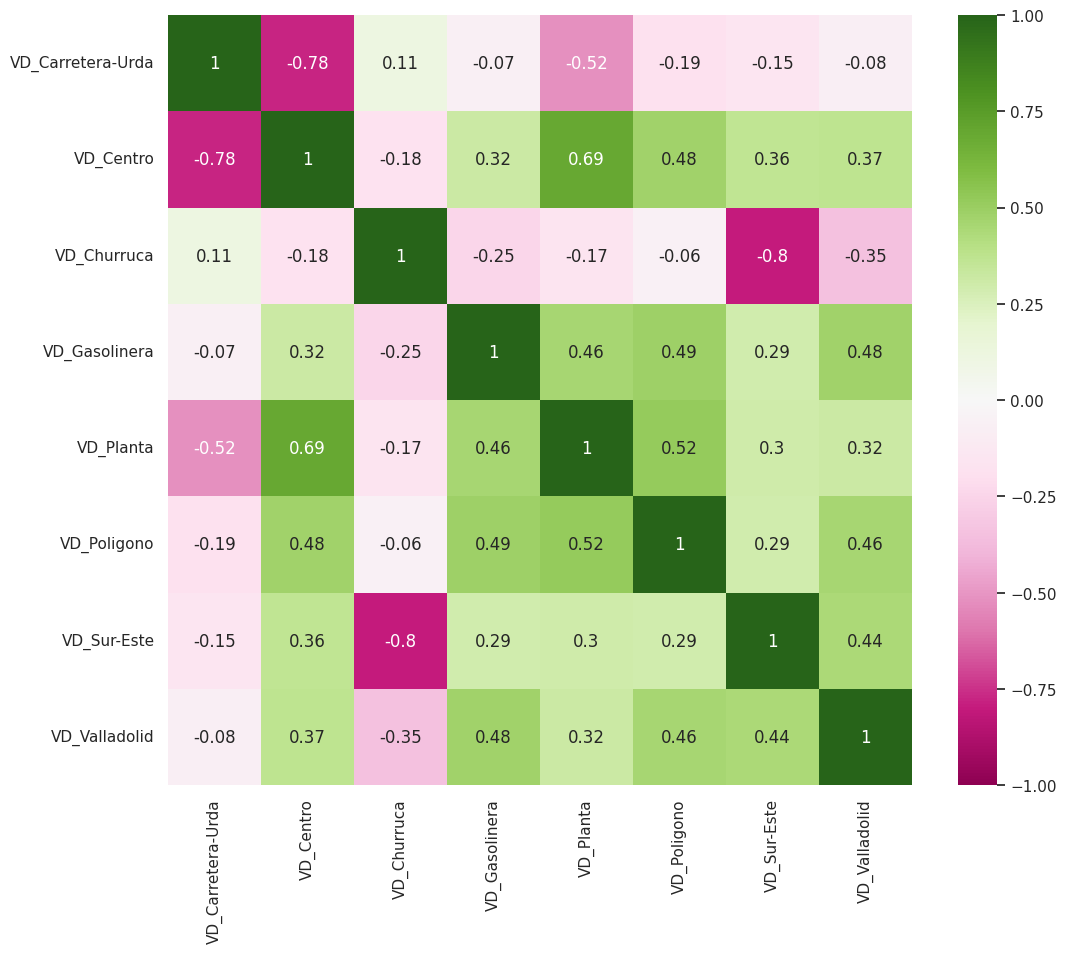

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

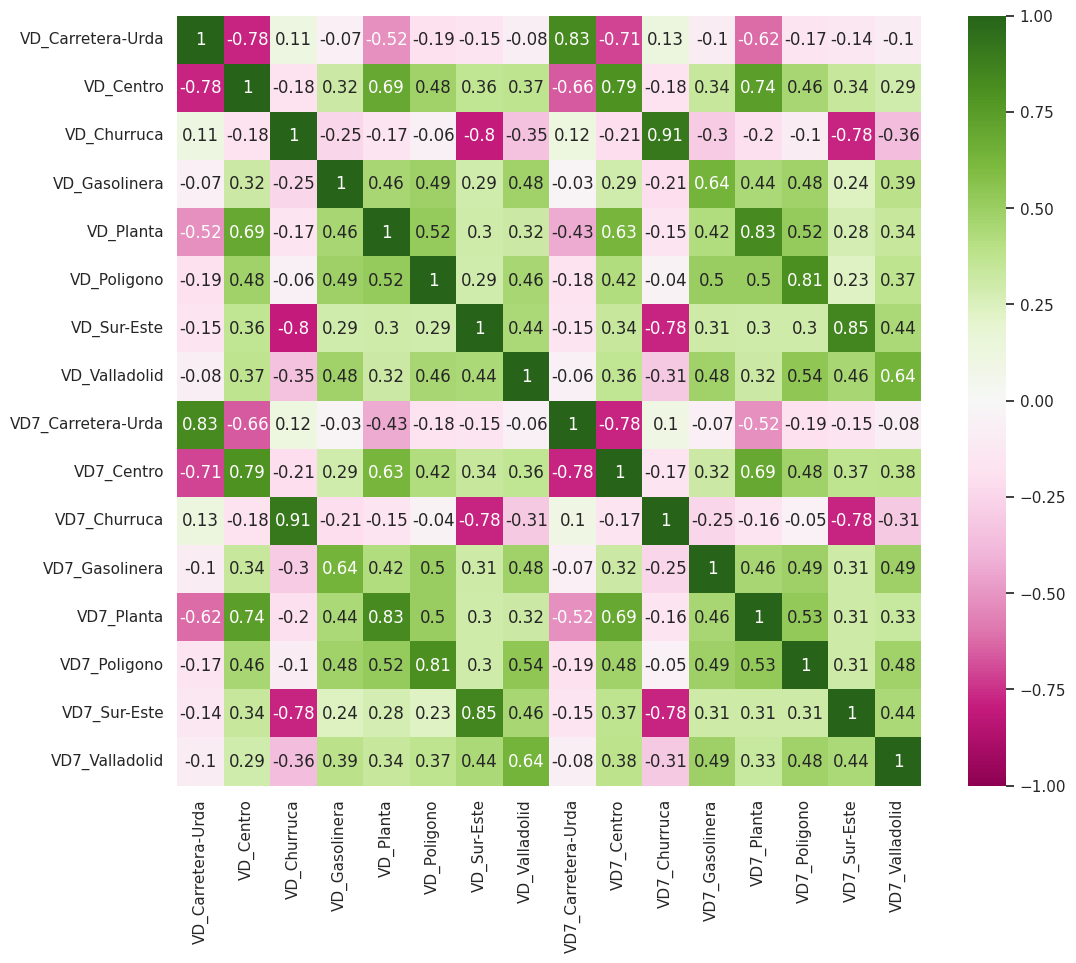

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9)) + list(range(31,39))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

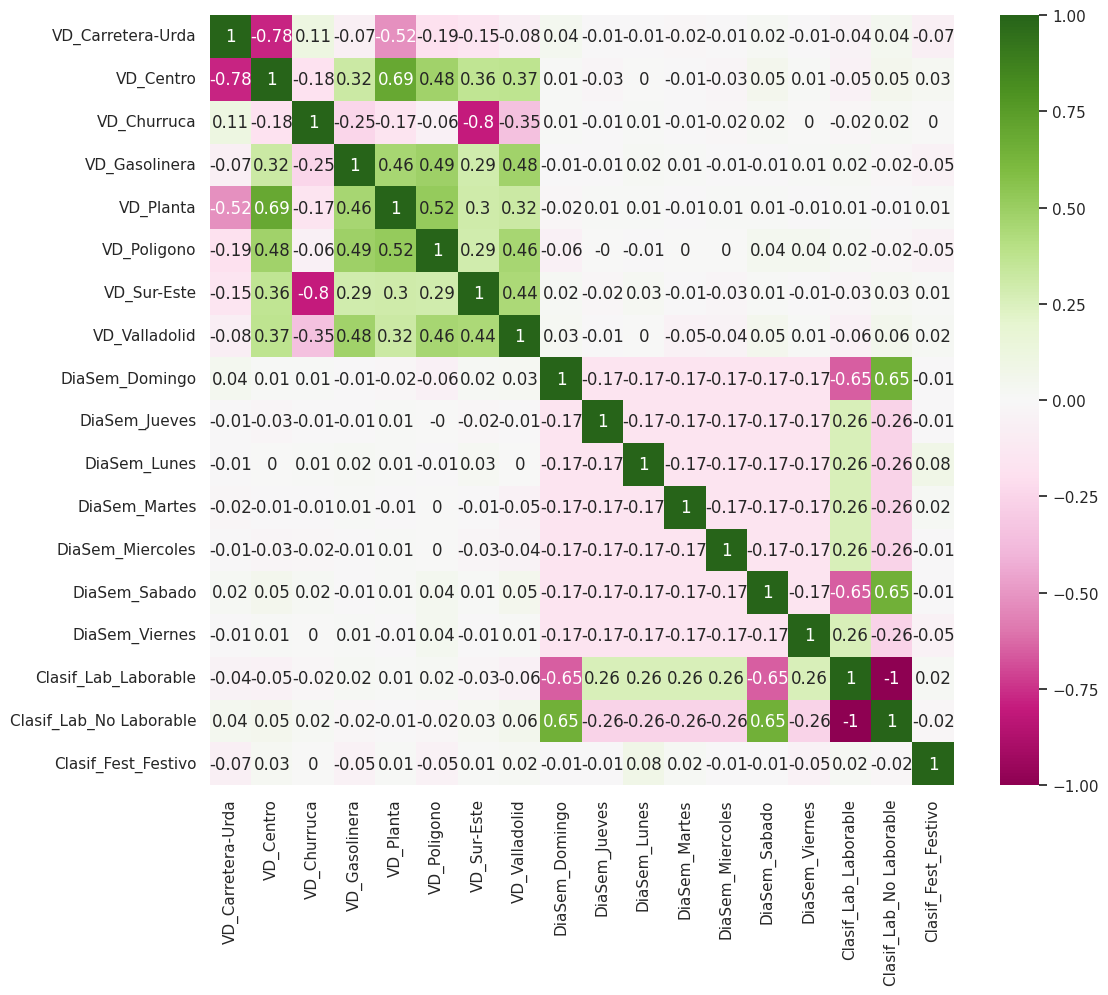

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9)) + list(range(9,19))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

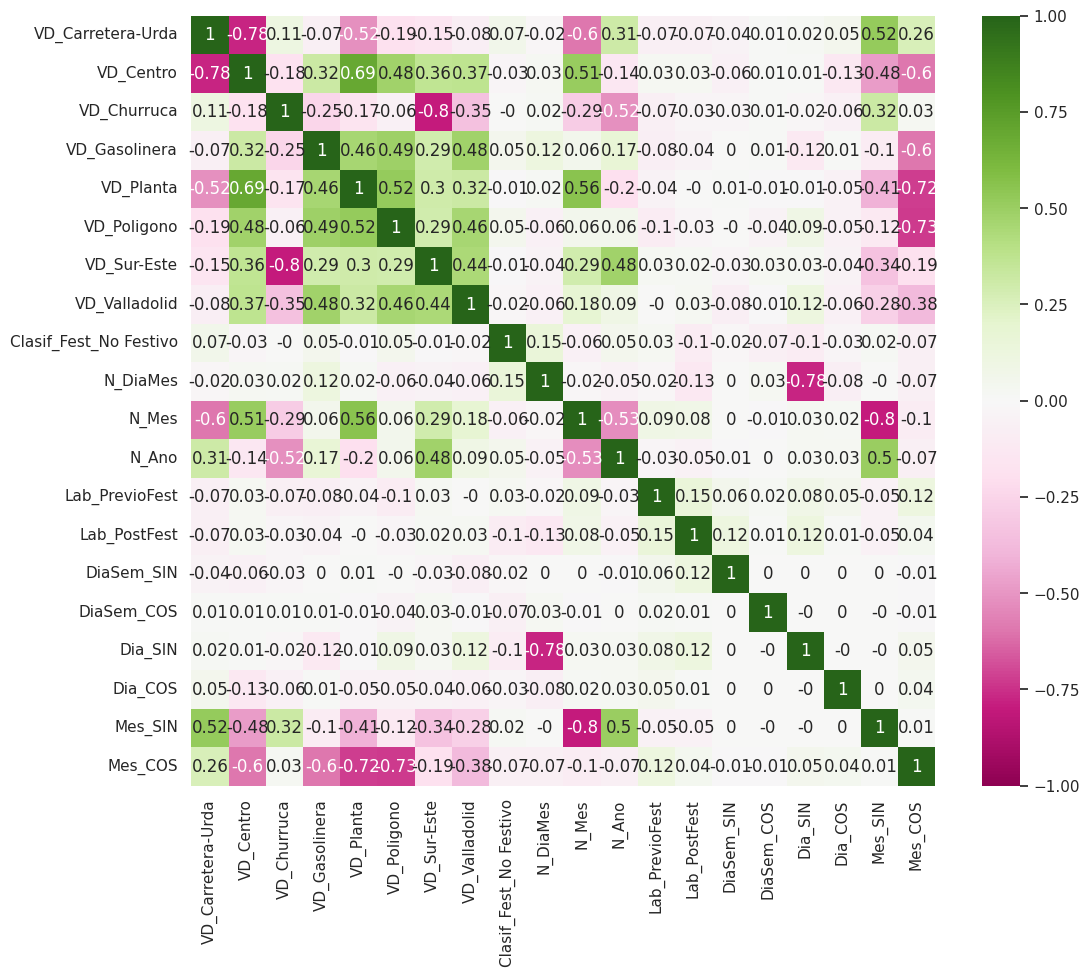

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9)) + list(range(19,31))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

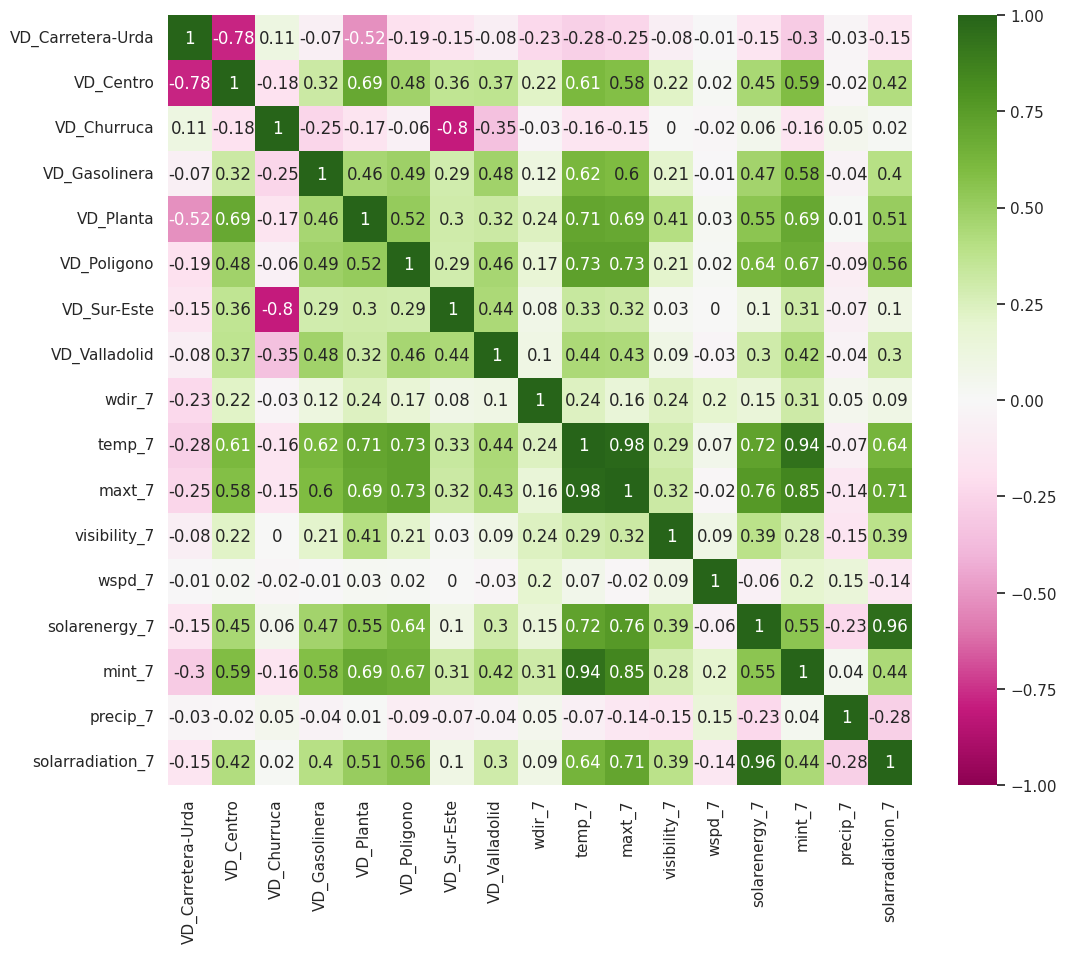

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9)) + list(range(39,48))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

<Axes: >

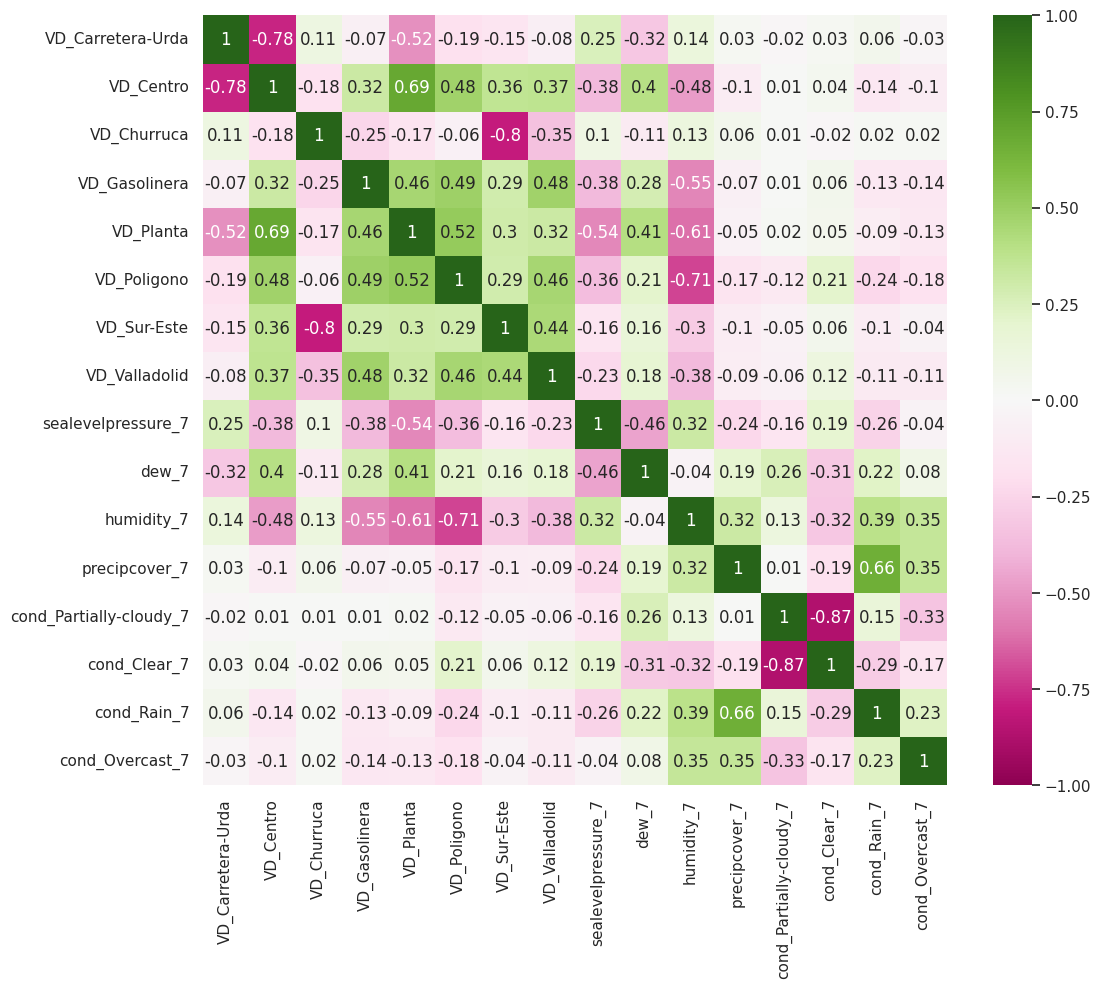

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
cols = list(range(1,9)) + list(range(48,56))
df_corr = df_encshift.iloc[:,cols].copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=True, cmap="PiYG")

In [ ]:
df_encshift.columns

Index(['RowKey_Date', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca',
       'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este',
       'VD_Valladolid', 'DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes',
       'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
       'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable',
       'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'N_DiaMes', 'N_Mes',
       'N_Ano', 'Lab_PrevioFest', 'Lab_PostFest', 'DiaSem_SIN', 'DiaSem_COS',
       'Dia_SIN', 'Dia_COS', 'Mes_SIN', 'Mes_COS', 'VD7_Carretera-Urda',
       'VD7_Centro', 'VD7_Churruca', 'VD7_Gasolinera', 'VD7_Planta',
       'VD7_Poligono', 'VD7_Sur-Este', 'VD7_Valladolid', 'wdir_7', 'temp_7',
       'maxt_7', 'visibility_7', 'wspd_7', 'solarenergy_7', 'mint_7',
       'precip_7', 'solarradiation_7', 'sealevelpressure_7', 'dew_7',
       'humidity_7', 'precipcover_7', 'cond_Partially-cloudy_7',
       'cond_Clear_7', 'cond_Rain_7', 'cond_Overcast_7'],
      dtype='

In [ ]:
sel_cols = ['RowKey_Date', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Churruca', 'VD_Gasolinera', 'VD_Planta', 'VD_Poligono', 'VD_Sur-Este', 'VD_Valladolid',
            'VD7_Carretera-Urda', 'VD7_Centro', 'VD7_Churruca', 'VD7_Gasolinera', 'VD7_Planta', 'VD7_Poligono', 'VD7_Sur-Este', 'VD7_Valladolid',
            'wdir_7', 'temp_7', 'maxt_7', 'visibility_7', 'solarenergy_7', 'mint_7', 'solarradiation_7', 'sealevelpressure_7', 'dew_7', 'humidity_7',
            'N_Mes', 'N_Ano', 'Mes_SIN', 'Mes_COS']

In [ ]:
df_sel = df_encshift[sel_cols].copy()
df_sel

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,VD7_Carretera-Urda,...,solarenergy_7,mint_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,N_Mes,N_Ano,Mes_SIN,Mes_COS
0,2021-08-09,33.34,221.00,"1,529.69",221.36,447.27,192.51,634.17,"1,244.30",110.09,...,24.40,14.20,452.70,"1,014.10",3.80,27.87,8,2021,-0.50,-0.87
1,2021-08-10,29.89,186.61,"1,449.94",160.97,433.40,223.56,657.64,"1,235.30",106.67,...,24.70,15.30,456.50,"1,015.10",7.70,35.15,8,2021,-0.50,-0.87
2,2021-08-11,23.73,214.44,"1,430.00",141.78,421.32,232.84,691.57,"1,238.70",74.18,...,25.30,21.20,468.30,"1,014.60",8.00,30.15,8,2021,-0.50,-0.87
3,2021-08-12,30.11,187.74,"1,448.75",139.11,418.45,209.98,711.72,"1,212.30",14.48,...,25.30,19.60,468.40,"1,014.80",5.50,25.73,8,2021,-0.50,-0.87
4,2021-08-13,20.03,223.59,"1,479.44",138.59,432.91,225.43,674.09,"1,278.60",21.05,...,25.50,22.20,471.70,"1,010.70",5.80,25.60,8,2021,-0.50,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2022-12-07,19.99,163.56,69.91,99.13,287.79,65.69,872.43,"1,028.90",19.67,...,8.00,-1.20,202.60,"1,017.50",2.10,77.15,12,2022,-0.50,0.87
486,2022-12-08,19.87,168.52,49.02,96.83,290.74,57.25,861.62,"1,046.60",19.65,...,9.50,5.00,263.40,"1,013.00",3.90,72.43,12,2022,-0.50,0.87
487,2022-12-09,19.79,167.96,69.84,96.40,290.37,60.48,874.39,"1,053.50",21.73,...,9.20,-1.00,254.60,"1,011.20",3.20,83.52,12,2022,-0.50,0.87
488,2022-12-10,20.62,178.30,40.18,95.57,313.51,62.17,877.48,"1,082.30",21.62,...,9.00,-2.00,250.80,"1,007.40",2.10,77.43,12,2022,-0.50,0.87


<ipython-input-169-5e94c926955d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

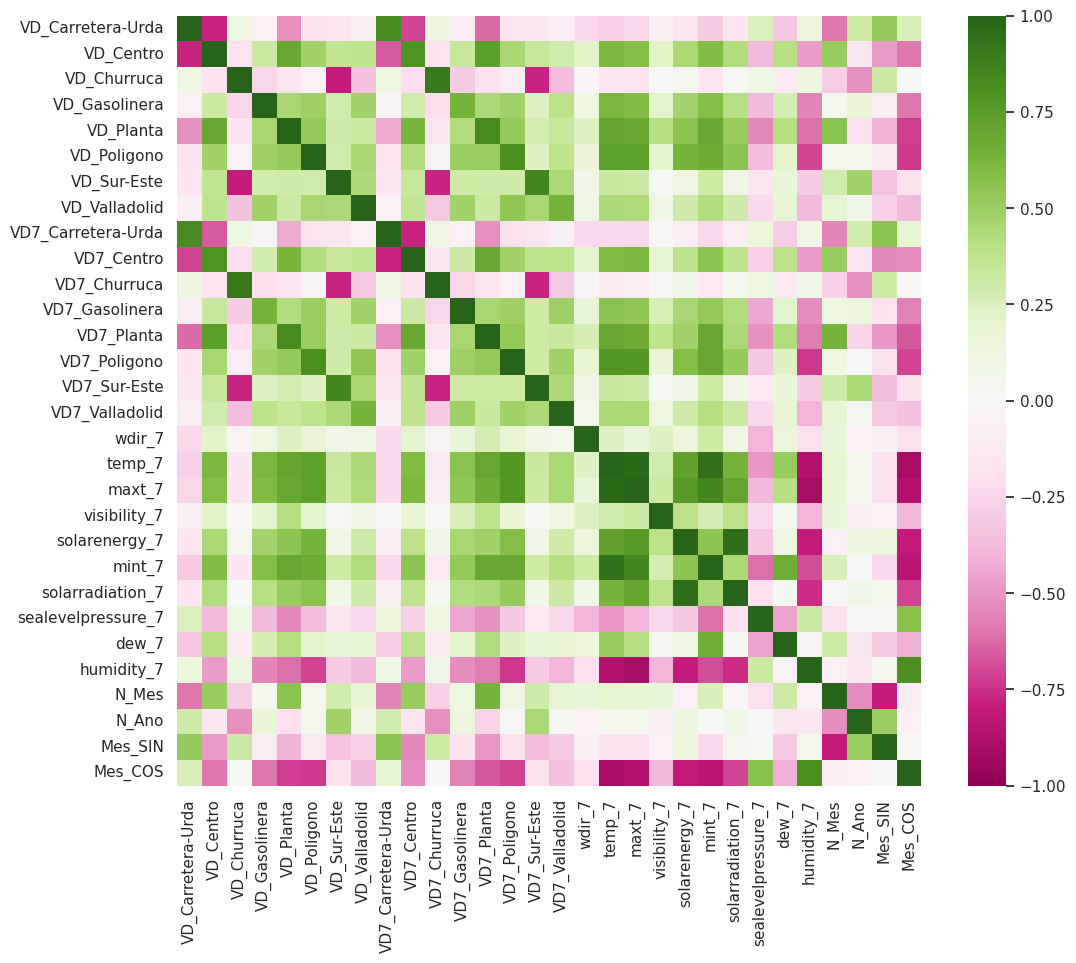

In [ ]:
sns.set(rc={'figure.figsize':(12,10)})
df_corr = df_sel.copy()
r = df_corr.corr()
sns.heatmap(r.round(2), vmin=-1, vmax=1, annot=False, cmap="PiYG")

## 2. ML MODEL: RANDOM FOREST

### MODEL 1 - DAILY PREDICTION

#### Target & Predictor variables

In [ ]:
df_model = df_encshift.copy()
df_model

,RowKey_Date,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid,DiaSem_Domingo,...,precip_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7,precipcover_7,cond_Partially-cloudy_7,cond_Clear_7,cond_Rain_7,cond_Overcast_7
0,2021-08-09,33.34,221.00,"1,529.69",221.36,447.27,192.51,634.17,"1,244.30",0.00,...,0.00,452.70,"1,014.10",3.80,27.87,0.00,1.00,0.00,0.00,0.00
1,2021-08-10,29.89,186.61,"1,449.94",160.97,433.40,223.56,657.64,"1,235.30",0.00,...,0.00,456.50,"1,015.10",7.70,35.15,0.00,1.00,0.00,0.00,0.00
2,2021-08-11,23.73,214.44,"1,430.00",141.78,421.32,232.84,691.57,"1,238.70",0.00,...,0.00,468.30,"1,014.60",8.00,30.15,0.00,0.00,1.00,0.00,0.00
3,2021-08-12,30.11,187.74,"1,448.75",139.11,418.45,209.98,711.72,"1,212.30",0.00,...,0.00,468.40,"1,014.80",5.50,25.73,0.00,0.00,1.00,0.00,0.00
4,2021-08-13,20.03,223.59,"1,479.44",138.59,432.91,225.43,674.09,"1,278.60",0.00,...,0.00,471.70,"1,010.70",5.80,25.60,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,2022-12-07,19.99,163.56,69.91,99.13,287.79,65.69,872.43,"1,028.90",0.00,...,0.00,202.60,"1,017.50",2.10,77.15,0.00,0.00,1.00,0.00,0.00
486,2022-12-08,19.87,168.52,49.02,96.83,290.74,57.25,861.62,"1,046.60",0.00,...,0.00,263.40,"1,013.00",3.90,72.43,0.00,0.00,1.00,0.00,0.00
487,2022-12-09,19.79,167.96,69.84,96.40,290.37,60.48,874.39,"1,053.50",0.00,...,0.00,254.60,"1,011.20",3.20,83.52,0.00,1.00,0.00,0.00,0.00
488,2022-12-10,20.62,178.30,40.18,95.57,313.51,62.17,877.48,"1,082.30",0.00,...,0.00,250.80,"1,007.40",2.10,77.43,0.00,1.00,0.00,0.00,0.00


In [ ]:
untarget_cols = []

In [ ]:
target_cols = [x for x in list(df_model.columns) if x.startswith('VD_')]
target_cols = list(set(target_cols) - set(untarget_cols))
target_cols

['VD_Sur-Este',
 'VD_Gasolinera',
 'VD_Valladolid',
 'VD_Carretera-Urda',
 'VD_Centro',
 'VD_Planta',
 'VD_Churruca',
 'VD_Poligono']

In [ ]:

unselect_vars = ['DiaSem_Domingo', 'DiaSem_Jueves', 'DiaSem_Lunes', 'DiaSem_Martes', 'DiaSem_Miercoles', 'DiaSem_Sabado', 'DiaSem_Viernes',
                 'Clasif_Lab_Laborable', 'Clasif_Lab_No Laborable', 'Clasif_Fest_Festivo', 'Clasif_Fest_No Festivo', 'Lab_PostFest', 'Lab_PrevioFest',
                 'N_Ano','DiaSem_SIN', 'DiaSem_COS', 'wdir_7', 'precip_7',
                 'precipcover_7', 'cond_Partially-cloudy_7','cond_Clear_7', 'cond_Rain_7', 'cond_Overcast_7']

'''
#N_Ano

unselect_vars = []
'''

'\n#N_Ano\n\nunselect_vars = []\n'

In [ ]:
select_vars = []
data_columns = list(df_model.columns)
data_columns = [x for x in data_columns if x not in target_cols]
cat_vars = df_model.select_dtypes(exclude=["number"]).columns

for x in data_columns:
  if (x not in cat_vars) & (x not in untarget_cols) & (x not in unselect_vars):
    select_vars.append(x)
  else:
    next

print(len(select_vars))
print(select_vars[:5])

24
['N_DiaMes', 'N_Mes', 'Dia_SIN', 'Dia_COS', 'Mes_SIN']


#### Test dates

In [ ]:

start_date = dt.date(2022, 12, 1)
end_date = dt.date(2022, 12, 5)    # perhaps date.now()
delta = end_date - start_date   # returns timedelta

test_dates = []
i = 0

for x in range(delta.days + 1):
  day = start_date + dt.timedelta(days=x)
  test_dates.append(str(day))

test_dates[:5]


['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04', '2022-12-05']

#### Model definition

In [ ]:
ML_model = RandomForestRegressor()  # n_estimators=100, max_depth=6, eta=0.3

In [ ]:
train_dict = {}
test_dict = {}

for x in target_cols:

  train_dict[x] = {}
  test_dict[x] = {}

  print('\n')
  print(f'Model Random Forest (Sector "{x}")')
  print('_'*70)

  for y in test_dates:

    day = dt.datetime.strptime(y, '%Y-%m-%d')
    y7 = str(day + dt.timedelta(days=6))

    start = time.time()

    X_train = df_model[(df_model['RowKey_Date']<y)][select_vars]
    y_train = df_model[(df_model['RowKey_Date']<y)][x].copy()
    y_train.reset_index(drop=True, inplace=True)
    y_train.rename("y_true", inplace=True)

    X_test = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][select_vars]
    y_test = df_model[(df_model['RowKey_Date']>=y)&(df_model['RowKey_Date']<=y7)][x].copy()
    y_test.reset_index(drop=True, inplace=True)
    y_test.rename("y_true", inplace=True)

    ML_model.fit(X_train, y_train)
    y_trainpred = pd.DataFrame(ML_model.predict(X_train), columns=['y_pred'])
    y_testpred = pd.DataFrame(ML_model.predict(X_test), columns=['y_pred'])

    train_res = pd.concat([y_train, y_trainpred], axis=1)
    test_res = pd.concat([y_test, y_testpred], axis=1).reset_index(drop=True)
    train_dict[x][y] = train_res
    test_dict[x][y] = test_res

    df_aux = pd.DataFrame(columns=['STA_Label','RowKey_Date'])
    df_aux = pd.concat([df_aux, pd.DataFrame(ML_model.feature_importances_, index=select_vars).transpose()], axis=1)
    df_aux.loc[:,'STA_Label'] = x
    df_aux.loc[:,'RowKey_Date'] = y

    if target_cols.index(x)==0 and test_dates.index(y)==0:
      imp_df = df_aux.copy()
    else:
      imp_df = pd.concat([imp_df, df_aux], axis=0)
      imp_df.reset_index(drop=True,inplace=True)
      imp_df

    end = time.time()
    #print('_'*35)
    print(f'-Test {y} ({timedelta(minutes=end-start)}))')
    #print('\n')




Model Random Forest (Sector "VD_Sur-Este")
______________________________________________________________________
-Test 2022-12-01 (0:02:35.129886))
-Test 2022-12-02 (0:03:03.572516))
-Test 2022-12-03 (0:01:29.882898))
-Test 2022-12-04 (0:01:27.883315))
-Test 2022-12-05 (0:01:48.094869))


Model Random Forest (Sector "VD_Gasolinera")
______________________________________________________________________
-Test 2022-12-01 (0:01:17.831554))
-Test 2022-12-02 (0:01:14.111280))
-Test 2022-12-03 (0:01:30.232372))
-Test 2022-12-04 (0:02:05.725894))
-Test 2022-12-05 (0:03:33.124580))


Model Random Forest (Sector "VD_Valladolid")
______________________________________________________________________
-Test 2022-12-01 (0:02:23.976903))
-Test 2022-12-02 (0:01:35.588923))
-Test 2022-12-03 (0:01:41.676607))
-Test 2022-12-04 (0:01:47.162619))
-Test 2022-12-05 (0:01:59.948974))


Model Random Forest (Sector "VD_Carretera-Urda")
______________________________________________________________________
-

In [ ]:
imp_df

,STA_Label,RowKey_Date,N_DiaMes,N_Mes,Dia_SIN,Dia_COS,Mes_SIN,Mes_COS,VD7_Carretera-Urda,VD7_Centro,...,temp_7,maxt_7,visibility_7,wspd_7,solarenergy_7,mint_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7
0,VD_Sur-Este,2022-12-01,0.02,0.03,0.00,0.00,0.00,0.10,0.00,0.01,...,0.01,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00
1,VD_Sur-Este,2022-12-02,0.02,0.03,0.00,0.01,0.00,0.09,0.00,0.00,...,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01
2,VD_Sur-Este,2022-12-03,0.02,0.03,0.00,0.01,0.00,0.09,0.00,0.00,...,0.01,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00
3,VD_Sur-Este,2022-12-04,0.02,0.03,0.00,0.01,0.00,0.09,0.00,0.00,...,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00
4,VD_Sur-Este,2022-12-05,0.02,0.03,0.00,0.00,0.00,0.09,0.00,0.00,...,0.01,0.00,0.01,0.01,0.00,0.02,0.00,0.00,0.00,0.00
5,VD_Gasolinera,2022-12-01,0.01,0.01,0.01,0.01,0.01,0.06,0.01,0.01,...,0.12,0.01,0.00,0.00,0.01,0.02,0.01,0.01,0.01,0.01
6,VD_Gasolinera,2022-12-02,0.01,0.01,0.01,0.01,0.01,0.05,0.03,0.01,...,0.11,0.01,0.00,0.01,0.01,0.02,0.01,0.01,0.02,0.02
7,VD_Gasolinera,2022-12-03,0.02,0.01,0.01,0.01,0.01,0.05,0.02,0.01,...,0.12,0.01,0.00,0.01,0.01,0.02,0.01,0.01,0.01,0.02
8,VD_Gasolinera,2022-12-04,0.02,0.01,0.01,0.01,0.01,0.04,0.03,0.01,...,0.16,0.01,0.00,0.01,0.01,0.02,0.01,0.01,0.01,0.02
9,VD_Gasolinera,2022-12-05,0.01,0.01,0.01,0.01,0.01,0.05,0.02,0.01,...,0.15,0.01,0.00,0.01,0.01,0.02,0.01,0.01,0.01,0.02


In [ ]:
imp_df.iloc[:,range(0,12)].groupby('STA_Label').mean()

<ipython-input-179-60b4a41042f1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,N_DiaMes,N_Mes,Dia_SIN,Dia_COS,Mes_SIN,Mes_COS,VD7_Carretera-Urda,VD7_Centro,VD7_Churruca,VD7_Gasolinera
STA_Label,,,,,,,,,,
VD_Carretera-Urda,0.00,0.00,0.00,0.02,0.00,0.01,0.68,0.03,0.02,0.00
VD_Centro,0.01,0.09,0.01,0.01,0.02,0.03,0.34,0.12,0.02,0.01
VD_Churruca,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.57,0.03
VD_Gasolinera,0.01,0.01,0.01,0.01,0.01,0.05,0.02,0.01,0.03,0.53
VD_Planta,0.01,0.67,0.01,0.00,0.00,0.02,0.00,0.00,0.01,0.03
VD_Poligono,0.04,0.00,0.01,0.01,0.00,0.35,0.01,0.02,0.01,0.01
VD_Sur-Este,0.02,0.03,0.00,0.01,0.00,0.09,0.00,0.00,0.43,0.03
VD_Valladolid,0.02,0.01,0.02,0.03,0.01,0.02,0.01,0.02,0.04,0.04


In [ ]:
imp_df.iloc[:,list(range(0,2))+list(range(12,20))].groupby('STA_Label').mean()

<ipython-input-180-7eeccfe0992f>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,VD7_Planta,VD7_Poligono,VD7_Sur-Este,VD7_Valladolid,temp_7,maxt_7,visibility_7,wspd_7
STA_Label,,,,,,,,
VD_Carretera-Urda,0.10,0.01,0.00,0.00,0.01,0.00,0.00,0.00
VD_Centro,0.19,0.00,0.01,0.00,0.05,0.04,0.00,0.00
VD_Churruca,0.01,0.02,0.29,0.01,0.01,0.01,0.00,0.00
VD_Gasolinera,0.01,0.04,0.01,0.01,0.13,0.01,0.00,0.01
VD_Planta,0.04,0.01,0.00,0.01,0.06,0.04,0.02,0.01
VD_Poligono,0.01,0.31,0.01,0.01,0.09,0.03,0.01,0.01
VD_Sur-Este,0.00,0.00,0.31,0.01,0.01,0.00,0.00,0.01
VD_Valladolid,0.01,0.01,0.04,0.56,0.04,0.03,0.02,0.01


In [ ]:
imp_df.iloc[:,list(range(0,2))+list(range(20,26))].groupby('STA_Label').mean()

<ipython-input-181-8217c746712b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,solarenergy_7,mint_7,solarradiation_7,sealevelpressure_7,dew_7,humidity_7
STA_Label,,,,,,
VD_Carretera-Urda,0.00,0.06,0.00,0.01,0.01,0.01
VD_Centro,0.01,0.02,0.00,0.00,0.01,0.00
VD_Churruca,0.00,0.00,0.00,0.00,0.00,0.01
VD_Gasolinera,0.01,0.02,0.01,0.01,0.01,0.02
VD_Planta,0.01,0.01,0.00,0.01,0.01,0.01
VD_Poligono,0.02,0.01,0.01,0.01,0.01,0.01
VD_Sur-Este,0.00,0.01,0.00,0.00,0.00,0.00
VD_Valladolid,0.02,0.01,0.01,0.00,0.01,0.03


#### Train/Test scores

In [ ]:
train_dict.keys()

dict_keys(['VD_Sur-Este', 'VD_Gasolinera', 'VD_Valladolid', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Planta', 'VD_Churruca', 'VD_Poligono'])

In [ ]:
train_dict['VD_Carretera-Urda']['2022-12-05']

,y_true,y_pred
0,33.34,33.54
1,29.89,30.05
2,23.73,26.26
3,30.11,32.93
4,20.03,28.80
...,...,...
478,19.67,18.48
479,19.65,19.08
480,21.73,20.14
481,21.62,22.92


In [ ]:
test_dict.keys()

dict_keys(['VD_Sur-Este', 'VD_Gasolinera', 'VD_Valladolid', 'VD_Carretera-Urda', 'VD_Centro', 'VD_Planta', 'VD_Churruca', 'VD_Poligono'])

In [ ]:
test_dict['VD_Carretera-Urda']['2022-12-05']

,y_true,y_pred
0,19.52,19.81
1,23.34,21.55
2,19.99,19.28
3,19.87,20.39
4,19.79,23.43
5,20.62,27.68
6,21.38,18.05


In [ ]:
target_cols[:5]

['VD_Sur-Este',
 'VD_Gasolinera',
 'VD_Valladolid',
 'VD_Carretera-Urda',
 'VD_Centro']

In [ ]:
test_dates[:5]

['2022-12-01', '2022-12-02', '2022-12-03', '2022-12-04', '2022-12-05']

In [ ]:

df_scores = pd.DataFrame(columns=['STA_Label','RowKey_Date','Train_MAPE','Train_MAE','Train_RMSE','Test_MAPE','Test_MAE','Test_RMSE'])
i = 0

for x in target_cols:
  for y in test_dates:

    df_scores.loc[i,'STA_Label'] = x
    df_scores.loc[i,'RowKey_Date'] = y

    # TRAIN SCORES
    y_true = train_dict[x][y].iloc[:,0]
    y_pred = train_dict[x][y].iloc[:,1]
    #mape = round(mean_absolute_percentage_error(y_true, y_pred), 4)
    mape = round(mape_corr(y_true, y_pred), 4)
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 4)

    df_scores.loc[i,'Train_MAPE'] = mape
    df_scores.loc[i,'Train_MAE'] = mae
    df_scores.loc[i,'Train_RMSE'] = rmse

    # TEST SCORES
    y_true = test_dict[x][y].iloc[:,0]
    y_pred = test_dict[x][y].iloc[:,1]
    #mape = round(mean_absolute_percentage_error(y_true, y_pred), 4)
    mape = round(mape_corr(y_true, y_pred), 4)
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    rmse = round(mean_squared_error(y_true, y_pred, squared=False), 4)

    df_scores.loc[i,'Test_MAPE'] = mape
    df_scores.loc[i,'Test_MAE'] = mae
    df_scores.loc[i,'Test_RMSE'] = rmse

    i += 1


In [ ]:
df_scores

,STA_Label,RowKey_Date,Train_MAPE,Train_MAE,Train_RMSE,Test_MAPE,Test_MAE,Test_RMSE
0,VD_Sur-Este,2022-12-01,0.07,12.20,25.04,0.08,70.13,104.71
1,VD_Sur-Este,2022-12-02,0.08,12.64,25.96,0.07,63.06,96.61
2,VD_Sur-Este,2022-12-03,0.07,12.29,23.04,0.06,49.70,97.96
3,VD_Sur-Este,2022-12-04,0.07,12.06,23.23,0.05,47.30,101.62
4,VD_Sur-Este,2022-12-05,0.07,12.04,22.64,0.05,45.53,93.26
5,VD_Gasolinera,2022-12-01,0,6.62,12.65,0.05,4.97,5.95
6,VD_Gasolinera,2022-12-02,0,6.91,12.82,0.07,6.62,7.33
7,VD_Gasolinera,2022-12-03,0,6.56,11.87,0.06,5.92,6.74
8,VD_Gasolinera,2022-12-04,0,7.11,13.30,0.05,4.48,4.81
9,VD_Gasolinera,2022-12-05,0,7.07,13.51,0.04,3.73,4.32


In [ ]:
final_scores = df_scores.groupby('STA_Label').mean().reset_index()
final_scores

<ipython-input-190-99a6e135f461>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,STA_Label,Train_MAPE,Train_MAE,Train_RMSE,Test_MAPE,Test_MAE,Test_RMSE
0,VD_Carretera-Urda,0.35,3.50,6.35,0.12,2.61,3.10
1,VD_Centro,0.00,5.45,10.41,0.05,9.12,10.55
2,VD_Churruca,0.00,31.20,71.87,6.84,138.51,281.79
3,VD_Gasolinera,0.00,6.85,12.83,0.05,5.14,5.83
4,VD_Planta,0.00,11.99,21.91,0.12,34.26,45.75
5,VD_Poligono,0.06,5.32,7.17,0.14,8.41,10.62
6,VD_Sur-Este,0.07,12.25,23.98,0.06,55.15,98.83
7,VD_Valladolid,0.00,31.20,60.21,0.11,117.01,144.63


In [ ]:
df_model.iloc[:,range(0,9)].describe()

,VD_Carretera-Urda,VD_Centro,VD_Churruca,VD_Gasolinera,VD_Planta,VD_Poligono,VD_Sur-Este,VD_Valladolid
count,490.00,490.00,490.00,490.00,490.00,490.00,490.00,490.00
mean,46.71,166.58,822.13,145.07,289.83,97.48,642.06,898.50
std,61.72,80.49,534.54,84.41,152.67,47.08,156.20,311.13
min,0.13,0.00,0.00,0.00,0.00,40.04,11.97,0.00
25%,10.98,153.06,51.20,86.50,277.56,60.25,527.36,740.92
50%,20.91,194.07,"1,041.06",133.23,337.92,79.56,584.41,821.50
75%,41.34,219.79,"1,175.59",167.90,390.13,133.35,765.49,"1,160.23"
max,217.07,292.38,"1,579.94",585.98,518.26,232.84,973.55,"1,528.40"


In [ ]:

for x in target_cols:
  for y in test_dates:

    df_train = train_dict[x][y]
    df_test = test_dict[x][y]

    if target_cols.index(x)==0 and test_dates.index(y)==0:
      preds_train = pd.DataFrame(columns=['y_true','y_pred'])
      preds_test = pd.DataFrame(columns=['y_true','y_pred'])
    else:
      preds_train = pd.concat([preds_train, df_train], axis=0)
      preds_train.reset_index(drop=True,inplace=True)

      preds_test = pd.concat([preds_test, df_test], axis=0)
      preds_test.reset_index(drop=True,inplace=True)


In [ ]:
preds_train

,y_true,y_pred
0,634.17,648.77
1,657.64,660.84
2,691.57,679.79
3,711.72,697.07
4,674.09,683.62
...,...,...
18756,74.74,69.43
18757,68.29,66.69
18758,61.38,62.35
18759,84.46,76.71


In [ ]:
preds_test

,y_true,y_pred
0,849.00,894.38
1,847.37,901.71
2,910.02,906.40
3,876.09,905.16
4,857.13,896.39
...,...,...
268,65.69,69.58
269,57.25,71.91
270,60.48,74.28
271,62.17,70.86


In [ ]:
preds_test[preds_test['y_pred']<0]

,y_true,y_pred


In [ ]:
df = pd.DataFrame(preds_test['y_true']-preds_test['y_pred'])
df

,0
0,-45.38
1,-54.34
2,3.62
3,-29.07
4,-39.26
...,...
268,-3.89
269,-14.66
270,-13.80
271,-8.69


In [ ]:
df[df[0]<-50]

,0
1,-54.34
67,-60.01
85,-59.62
209,-772.70
214,-72.43
215,-735.55
216,-74.43
220,-120.82
221,-719.87
226,-107.64


In [ ]:
df[df[0]>200]

,0
5,238.65
11,254.97
17,266.72
23,244.17
69,274.76
75,216.86
76,229.20
81,239.39
82,243.62
83,271.37


In [ ]:
Train_MAPE = mape_corr(preds_train['y_true'], preds_train['y_pred'])*100
Train_MAE = mean_absolute_error(preds_train['y_true'], preds_train['y_pred'])
Train_RMSE = mean_squared_error(preds_train['y_true'], preds_train['y_pred'], squared=False)

Test_MAPE = mape_corr(preds_test['y_true'], preds_test['y_pred'])*100
Test_MAE = mean_absolute_error(preds_test['y_true'], preds_test['y_pred'])
Test_RMSE = mean_squared_error(preds_test['y_true'], preds_test['y_pred'], squared=False)

#### Results

In [ ]:
print('Train scores:')
print(f'MAPE = {Train_MAPE:.4f} %')
print(f'MAE = {Train_MAE:.4f}')
print(f'RMSE = {Train_RMSE:.4f}')

print('Test scores:')
print(f'MAPE = {Test_MAPE:.4f} %')
print(f'MAE = {Test_MAE:.4f}')
print(f'RMSE = {Test_RMSE:.4f}')

Train scores:
MAPE = 0.0000 %
MAE = 13.5026
RMSE = 35.9717
Test scores:
MAPE = 95.9392 %
MAE = 45.6662
RMSE = 119.2511
